In [1]:
from torch import nn
import torch
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import numpy as np

import pandas as pd

from model import train, test

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [2]:
raw_data = pd.read_csv('D:\datasets\epileptic_seizure_eeg\Epileptic_Seizure_Recognition.csv')

In [3]:
raw_data.head()

,Unnamed,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,5


In [4]:
df = raw_data.drop(columns=['Unnamed'])

# Labels to binary 
# Only 1 means epileptic seizure, 2-5 mean other things but no seizure
df['y'] = (df['y'] == 1).astype(int)

X = df.drop(columns=['y']).values
y = df['y'].values

In [5]:
counts = df['y'].value_counts()
percentages = df['y'].value_counts(normalize=True) * 100

balance_info = pd.DataFrame({
    'Amount of trials': counts,
    'Percentage': percentages.round(2)
})

balance_info.index = balance_info.index.map({1: 'Seizure (1)', 0: 'No Seizure (0)'})

print(balance_info)

                Amount of trials  Percentage
y                                           
No Seizure (0)              9200        80.0
Seizure (1)                 2300        20.0


In [6]:
# Train, val, test split (80, 10, 10)

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

In [7]:
# Scaling for gradient stability to reduce impact from having different patients
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [8]:
train_dataset = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32), 
    torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
)
val_dataset = TensorDataset(
    torch.tensor(X_val, dtype=torch.float32), 
    torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
)
test_dataset = TensorDataset(
    torch.tensor(X_test, dtype=torch.float32), 
    torch.tensor(y_test, dtype=torch.float32).view(-1, 1)
)

In [9]:
# Data Loaders params
params = {
    'batch_size': 64,
    'shuffle': True,
    'num_workers': 0
}

In [10]:
train_loader = DataLoader(train_dataset, **params)
val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=params['batch_size'], shuffle=False)

In [11]:
from rnn import SimpleRNN

simple_rnn = SimpleRNN()

In [12]:
import torch.optim as optim
loss_fn = nn.BCEWithLogitsLoss()

<h3>Simple RNN</h3>

In [13]:
simple_rnn.to(device)

SimpleRNN(
  (rnn): RNN(1, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

[Epoch: 1] Train loss: 26.70 | Train acc: 81.04% | Val loss: 17.44 | Val acc: 84.26%
[Epoch: 2] Train loss: 25.07 | Train acc: 78.29% | Val loss: 28.00 | Val acc: 83.48%
[Epoch: 3] Train loss: 25.41 | Train acc: 83.53% | Val loss: 20.84 | Val acc: 85.30%
[Epoch: 4] Train loss: 19.28 | Train acc: 86.42% | Val loss: 16.91 | Val acc: 85.74%
[Epoch: 5] Train loss: 17.02 | Train acc: 89.82% | Val loss: 17.05 | Val acc: 88.52%
[Epoch: 6] Train loss: 18.25 | Train acc: 87.60% | Val loss: 22.14 | Val acc: 85.83%
[Epoch: 7] Train loss: 28.93 | Train acc: 83.23% | Val loss: 33.17 | Val acc: 79.91%
[Epoch: 8] Train loss: 33.08 | Train acc: 79.14% | Val loss: 47.30 | Val acc: 45.74%
[Epoch: 9] Train loss: 33.00 | Train acc: 74.89% | Val loss: 27.00 | Val acc: 82.78%
[Epoch: 10] Train loss: 25.59 | Train acc: 83.05% | Val loss: 21.50 | Val acc: 85.65%
[Epoch: 11] Train loss: 22.31 | Train acc: 85.24% | Val loss: 17.93 | Val acc: 87.74%
[Epoch: 12] Train loss: 20.51 | Train acc: 85.93% | Val loss: 1

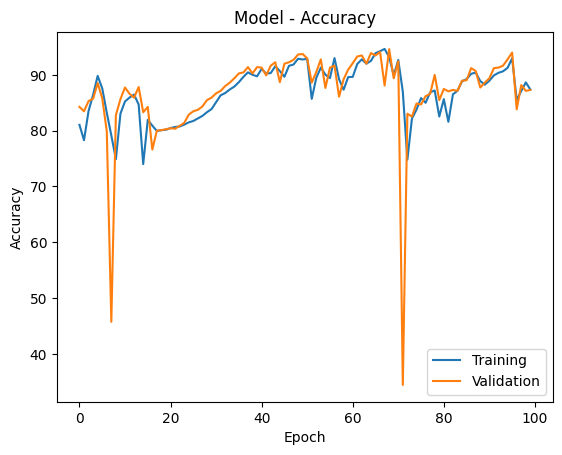

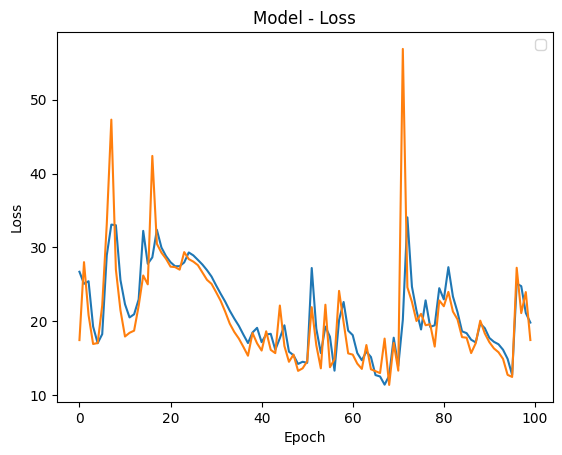

In [14]:
optimizer = optim.Adam(simple_rnn.parameters(), lr=0.001)
train(simple_rnn, train_loader, val_loader, optimizer, loss_fn, 100, params['batch_size'], device)

In [15]:
test(simple_rnn, test_loader, loss_fn, device)


--- Test Results ---
Loss:      0.2965
Accuracy:  87.48%


<h3>Single LSTM</h3>

In [16]:
from rnn import LSTM_RNN

lstm_rnn = LSTM_RNN()
lstm_rnn.to(device)

LSTM_RNN(
  (lstm): LSTM(1, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

[Epoch: 1] Train loss: 24.68 | Train acc: 82.79% | Val loss: 12.09 | Val acc: 95.22%
[Epoch: 2] Train loss: 12.97 | Train acc: 93.91% | Val loss: 10.89 | Val acc: 94.26%
[Epoch: 3] Train loss: 27.83 | Train acc: 79.52% | Val loss: 14.43 | Val acc: 94.78%
[Epoch: 4] Train loss: 18.08 | Train acc: 92.33% | Val loss: 15.80 | Val acc: 93.22%
[Epoch: 5] Train loss: 14.97 | Train acc: 91.20% | Val loss: 12.74 | Val acc: 92.78%
[Epoch: 6] Train loss: 10.97 | Train acc: 93.40% | Val loss: 11.18 | Val acc: 94.26%
[Epoch: 7] Train loss: 9.94 | Train acc: 94.29% | Val loss: 10.10 | Val acc: 95.48%
[Epoch: 8] Train loss: 9.37 | Train acc: 95.07% | Val loss: 9.20 | Val acc: 95.48%
[Epoch: 9] Train loss: 8.26 | Train acc: 95.76% | Val loss: 8.24 | Val acc: 96.35%
[Epoch: 10] Train loss: 8.64 | Train acc: 95.86% | Val loss: 11.53 | Val acc: 95.65%
[Epoch: 11] Train loss: 46.22 | Train acc: 62.74% | Val loss: 33.65 | Val acc: 77.91%
[Epoch: 12] Train loss: 18.18 | Train acc: 87.96% | Val loss: 15.56 |

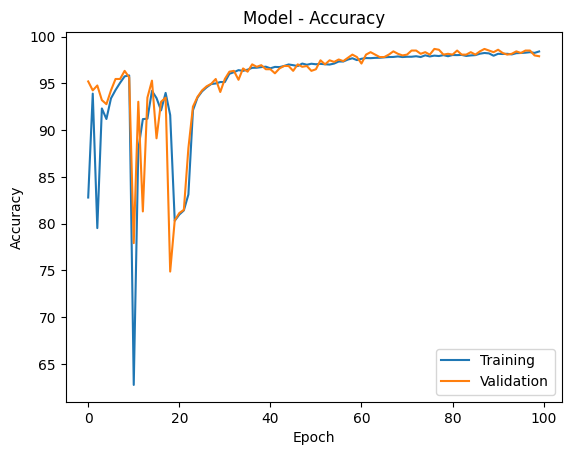

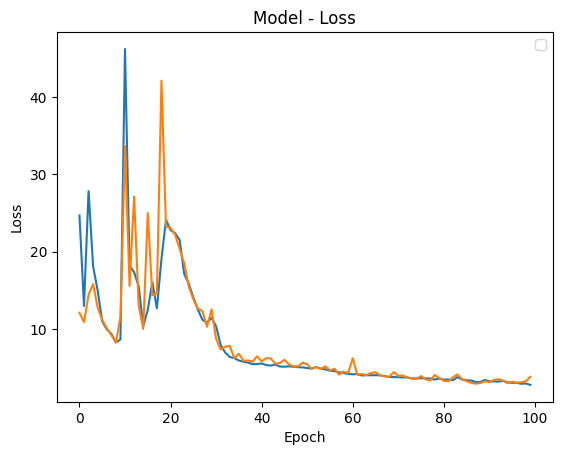

In [17]:
optimizer = optim.Adam(lstm_rnn.parameters(), lr=0.001)
train(lstm_rnn, train_loader, val_loader, optimizer, loss_fn, 100, params['batch_size'], device)

In [18]:
test(lstm_rnn, test_loader, loss_fn, device)


--- Test Results ---
Loss:      0.0709
Accuracy:  97.48%


<h3>Single GRU</h3>

In [19]:
from rnn import GRU_RNN

gru_rnn = GRU_RNN()
gru_rnn.to(device)

GRU_RNN(
  (gru): GRU(1, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

[Epoch: 1] Train loss: 22.59 | Train acc: 85.37% | Val loss: 8.92 | Val acc: 95.22%
[Epoch: 2] Train loss: 7.73 | Train acc: 95.72% | Val loss: 7.92 | Val acc: 96.26%
[Epoch: 3] Train loss: 8.57 | Train acc: 94.28% | Val loss: 9.45 | Val acc: 93.30%
[Epoch: 4] Train loss: 6.70 | Train acc: 95.98% | Val loss: 8.99 | Val acc: 96.09%
[Epoch: 5] Train loss: 6.73 | Train acc: 96.48% | Val loss: 6.08 | Val acc: 97.04%
[Epoch: 6] Train loss: 5.95 | Train acc: 96.82% | Val loss: 7.20 | Val acc: 95.57%
[Epoch: 7] Train loss: 5.43 | Train acc: 97.15% | Val loss: 5.82 | Val acc: 96.70%
[Epoch: 8] Train loss: 5.36 | Train acc: 97.02% | Val loss: 5.89 | Val acc: 97.48%
[Epoch: 9] Train loss: 5.21 | Train acc: 97.13% | Val loss: 5.04 | Val acc: 98.17%
[Epoch: 10] Train loss: 5.10 | Train acc: 97.26% | Val loss: 5.18 | Val acc: 97.22%
[Epoch: 11] Train loss: 5.06 | Train acc: 97.10% | Val loss: 4.86 | Val acc: 98.17%
[Epoch: 12] Train loss: 6.43 | Train acc: 96.58% | Val loss: 5.09 | Val acc: 97.48%


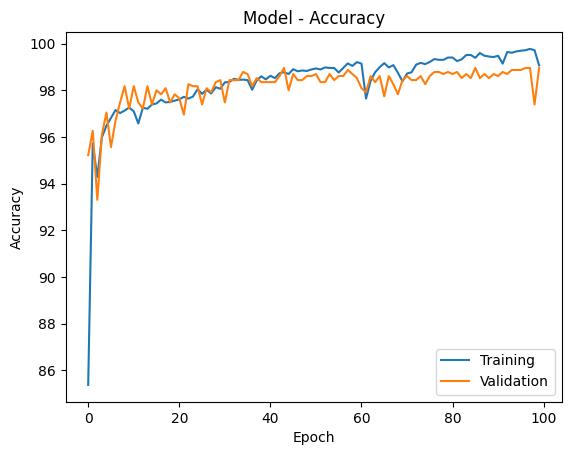

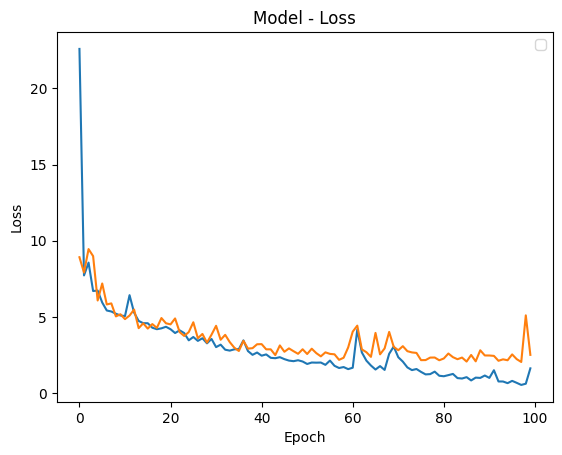

In [20]:
optimizer = optim.Adam(gru_rnn.parameters(), lr=0.001)
train(gru_rnn, train_loader, val_loader, optimizer, loss_fn, 100, params['batch_size'], device)

In [21]:
test(gru_rnn, test_loader, loss_fn, device)


--- Test Results ---
Loss:      0.0485
Accuracy:  98.43%


<h3>RNN from paper</h3>
Epilepsy Detection in EEG Signal using Recurrent Neural Network, I. Aliyu et al 2019 <br>
3 x LSTM + 0.25 dropout | hidden size: 256 

In [13]:
from rnn import SOTA_RNN

sota_rnn = SOTA_RNN()
sota_rnn.to(device)

SOTA_RNN(
  (lstm): LSTM(1, 256, num_layers=3, batch_first=True, dropout=0.25)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)

[Epoch: 1] Train loss: 23.90 | Train acc: 87.32% | Val loss: 13.97 | Val acc: 93.57%
[Epoch: 2] Train loss: 14.09 | Train acc: 92.99% | Val loss: 12.26 | Val acc: 95.04%
[Epoch: 3] Train loss: 11.14 | Train acc: 94.63% | Val loss: 9.63 | Val acc: 94.96%
[Epoch: 4] Train loss: 17.29 | Train acc: 89.02% | Val loss: 9.55 | Val acc: 94.52%
[Epoch: 5] Train loss: 10.79 | Train acc: 93.96% | Val loss: 20.86 | Val acc: 85.74%
[Epoch: 6] Train loss: 26.07 | Train acc: 85.41% | Val loss: 26.84 | Val acc: 85.30%
[Epoch: 7] Train loss: 26.08 | Train acc: 85.48% | Val loss: 26.62 | Val acc: 85.04%
[Epoch: 8] Train loss: 13.61 | Train acc: 92.84% | Val loss: 7.57 | Val acc: 96.17%
[Epoch: 9] Train loss: 7.38 | Train acc: 95.59% | Val loss: 6.37 | Val acc: 96.61%
[Epoch: 10] Train loss: 5.85 | Train acc: 96.51% | Val loss: 6.32 | Val acc: 96.61%
[Epoch: 11] Train loss: 6.09 | Train acc: 96.82% | Val loss: 6.53 | Val acc: 96.17%
[Epoch: 12] Train loss: 6.25 | Train acc: 96.33% | Val loss: 7.31 | Val 

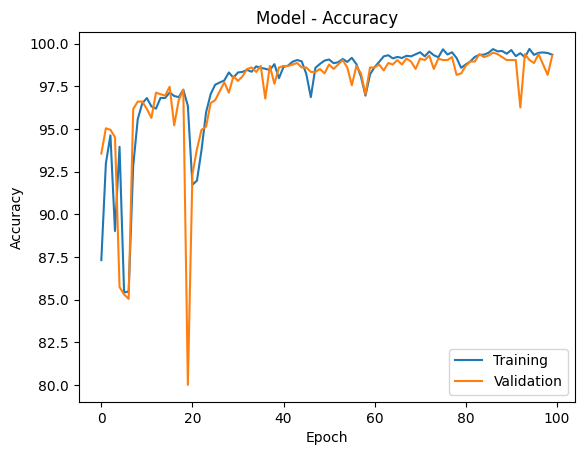

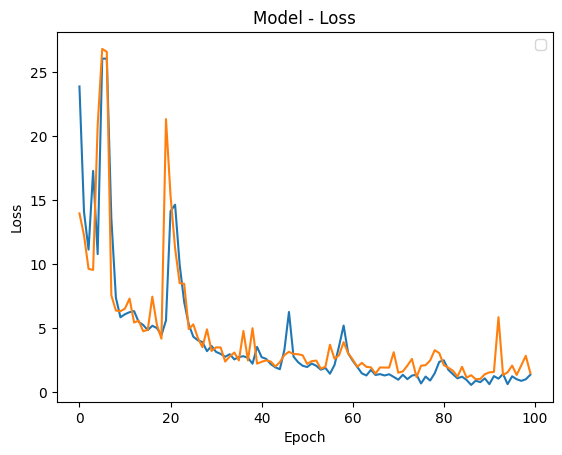

In [15]:
optimizer = optim.Adam(sota_rnn.parameters(), lr=0.001)
train(sota_rnn, train_loader, val_loader, optimizer, loss_fn, 100, params['batch_size'], device)

In [16]:
test(sota_rnn, test_loader, loss_fn, device)


--- Test Results ---
Loss:      0.0348
Accuracy:  98.70%
